In [255]:
import pandas as pd
import geopandas as gpd
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
from functools import partial
from rasterio.enums import MergeAlg
from shapely.geometry import LineString
import matplotlib as plt
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt2
import rasterio as rio
import numpy as np
from scipy import stats
import requests
from io import BytesIO
from zipfile import ZipFile
from functools import partial
import pygeohash as gh
from shapely.geometry import Polygon

In [256]:
url = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/NYC_AQ.csv'
NYC_AQ = pd.read_csv(url)

url = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson'
NYC_geojson = gpd.read_file(url)

In [257]:
print(NYC_AQ.head())
print(NYC_geojson.head())

      SensorID        time   latitude  longitude  bin0  bin1  bin2  bin3  \
0  NYCP2_CS01A  1631277304  40.847672 -73.869316    11     1     1     0   
1  NYCP2_CS01A  1631277308  40.847668 -73.869316    22     4     1     0   
2  NYCP2_CS01A  1631277313  40.847649 -73.869362    40     1     1     0   
3  NYCP2_CS01A  1631277318  40.847649 -73.869362    26     1     0     0   
4  NYCP2_CS01A  1631277323  40.847649 -73.869362    44     4     0     1   

   bin4  bin5  ...  bin17  bin18  bin19  bin20  bin21  bin22  bin23  \
0     0     0  ...      0      0      0      0      0      0      0   
1     0     2  ...      0      0      0      0      0      0      0   
2     0     1  ...      0      0      0      0      0      0      0   
3     0     0  ...      0      0      0      0      0      0      0   
4     0     0  ...      0      0      0      0      0      0      0   

   temperature  humidity      pm25  
0         23.7      57.3  4.508813  
1         23.7      57.8  5.462420  
2    

In [258]:
def Data_pre_processing(NYC_AQ):
    columns_to_keep = ['latitude', 'longitude', 'pm25']
    NYC_AQ = NYC_AQ[columns_to_keep]

    NYC_AQ = NYC_AQ[(NYC_AQ['latitude'] != 0) & (NYC_AQ['longitude'] != 0)]

    NYC_AQ['longitude'] = pd.to_numeric(NYC_AQ['longitude'])
    NYC_AQ['latitude'] = pd.to_numeric(NYC_AQ['latitude'])
    return NYC_AQ

In [259]:
NYC_AQ = Data_pre_processing(NYC_AQ)
print(NYC_AQ)

         latitude  longitude      pm25
0       40.847672 -73.869316  4.508813
1       40.847668 -73.869316  5.462420
2       40.847649 -73.869362  5.154881
3       40.847649 -73.869362  4.508813
4       40.847649 -73.869362  5.539503
...           ...        ...       ...
169994  40.823353 -73.890488  5.460360
169995  40.823349 -73.890480  5.298209
169996  40.823349 -73.890480  6.470661
169997  40.823345 -73.890488  6.424142
169998  40.823338 -73.890488  6.526187

[169999 rows x 3 columns]


In [260]:
geohash_precision = 7
NYC_AQ['geohash']=NYC_AQ.apply(lambda x: gh.encode(x.latitude, x.longitude, precision=geohash_precision), axis=1)
NYC_AQ.head()

,latitude,longitude,pm25,geohash
0,40.847672,-73.869316,4.508813,dr72rh4
1,40.847668,-73.869316,5.462420,dr72rh4
2,40.847649,-73.869362,5.154881,dr72rh1
3,40.847649,-73.869362,4.508813,dr72rh1
4,40.847649,-73.869362,5.539503,dr72rh1


In [261]:
NYC_AQ = gpd.GeoDataFrame(NYC_AQ, geometry = gpd.points_from_xy(x=NYC_AQ['longitude'], y=NYC_AQ['latitude']))
NYC_AQ = NYC_AQ.set_crs('EPSG:4326')
NYC_AQ

,latitude,longitude,pm25,geohash,geometry
0,40.847672,-73.869316,4.508813,dr72rh4,POINT (-73.86932 40.84767)
1,40.847668,-73.869316,5.462420,dr72rh4,POINT (-73.86932 40.84767)
2,40.847649,-73.869362,5.154881,dr72rh1,POINT (-73.86936 40.84765)
3,40.847649,-73.869362,4.508813,dr72rh1,POINT (-73.86936 40.84765)
4,40.847649,-73.869362,5.539503,dr72rh1,POINT (-73.86936 40.84765)
...,...,...,...,...,...
169994,40.823353,-73.890488,5.460360,dr72nxd,POINT (-73.89049 40.82335)
169995,40.823349,-73.890480,5.298209,dr72nxd,POINT (-73.89048 40.82335)
169996,40.823349,-73.890480,6.470661,dr72nxd,POINT (-73.89048 40.82335)
169997,40.823345,-73.890488,6.424142,dr72nxd,POINT (-73.89049 40.82335)


In [262]:
def decode_geohash(geohash):
    """Decode the geohash to its bounding box (longitude and latitude ranges)."""

    # Geohash character-to-binary mapping
    base32_map = '0123456789bcdefghjkmnpqrstuvwxyz'
    base32_dict = {char: "{:05b}".format(i) for i, char in enumerate(base32_map)}

    # Split geohash into bits for longitude and latitude
    bits = ''.join(base32_dict[c] for c in geohash)
    lon_bits = bits[::2]
    lat_bits = bits[1::2]

    # Function to decode bits to a range
    def decode_range(bits, range_min, range_max):
        for bit in bits:
            mid = (range_min + range_max) / 2
            if bit == '1':
                range_min = mid
            else:
                range_max = mid
        return (range_min, range_max)

    # Decode longitude and latitude ranges
    lon_range = decode_range(lon_bits, -180, 180)
    lat_range = decode_range(lat_bits, -90, 90)

    # Return the bounding box as a dictionary
    return {
        'w': lon_range[0],
        'e': lon_range[1],
        's': lat_range[0],
        'n': lat_range[1],
    }

In [263]:
def bbox_to_polygon(temp):
    temp['geometry'] = temp['bbox'].apply(lambda b: Polygon([
    (b['w'], b['s']),
    (b['w'], b['n']),
    (b['e'], b['n']),
    (b['e'], b['s'])
                    ]))
    return temp

In [264]:
def geohash_to_polygons(NYC_AQ):
    temp = pd.DataFrame(columns=['bbox'])
    temp['bbox'] = NYC_AQ['geohash'].apply(decode_geohash)
    temp = bbox_to_polygon(temp)
    NYC_AQ = gpd.GeoDataFrame(NYC_AQ, geometry = temp['geometry'])
    return NYC_AQ

In [265]:
NYC_AQ = geohash_to_polygons(NYC_AQ)
NYC_AQ.head()

,latitude,longitude,pm25,geohash,geometry
0,40.847672,-73.869316,4.508813,dr72rh4,"POLYGON ((-73.86932 40.84717, -73.86932 40.848..."
1,40.847668,-73.869316,5.462420,dr72rh4,"POLYGON ((-73.86932 40.84717, -73.86932 40.848..."
2,40.847649,-73.869362,5.154881,dr72rh1,"POLYGON ((-73.87070 40.84717, -73.87070 40.848..."
3,40.847649,-73.869362,4.508813,dr72rh1,"POLYGON ((-73.87070 40.84717, -73.87070 40.848..."
4,40.847649,-73.869362,5.539503,dr72rh1,"POLYGON ((-73.87070 40.84717, -73.87070 40.848..."


In [266]:
def decode_geohash(geohash):
    latitude, longitude, _, _ = gh.decode_exactly(geohash)
    return pd.Series([latitude, longitude])

In [267]:
NYC_AQ[['geohash_center_latitude', 'geohash_center_longitude']] = NYC_AQ['geohash'].apply(decode_geohash)
NYC_AQ

,latitude,longitude,pm25,geohash,geometry,geohash_center_latitude,geohash_center_longitude
0,40.847672,-73.869316,4.508813,dr72rh4,"POLYGON ((-73.86932 40.84717, -73.86932 40.848...",40.847855,-73.868637
1,40.847668,-73.869316,5.462420,dr72rh4,"POLYGON ((-73.86932 40.84717, -73.86932 40.848...",40.847855,-73.868637
2,40.847649,-73.869362,5.154881,dr72rh1,"POLYGON ((-73.87070 40.84717, -73.87070 40.848...",40.847855,-73.870010
3,40.847649,-73.869362,4.508813,dr72rh1,"POLYGON ((-73.87070 40.84717, -73.87070 40.848...",40.847855,-73.870010
4,40.847649,-73.869362,5.539503,dr72rh1,"POLYGON ((-73.87070 40.84717, -73.87070 40.848...",40.847855,-73.870010
...,...,...,...,...,...,...,...
169994,40.823353,-73.890488,5.460360,dr72nxd,"POLYGON ((-73.89130 40.82245, -73.89130 40.823...",40.823135,-73.890610
169995,40.823349,-73.890480,5.298209,dr72nxd,"POLYGON ((-73.89130 40.82245, -73.89130 40.823...",40.823135,-73.890610
169996,40.823349,-73.890480,6.470661,dr72nxd,"POLYGON ((-73.89130 40.82245, -73.89130 40.823...",40.823135,-73.890610
169997,40.823345,-73.890488,6.424142,dr72nxd,"POLYGON ((-73.89130 40.82245, -73.89130 40.823...",40.823135,-73.890610


In [269]:
NYC_AQ['geohash_encoding_key'] = geohash_precision
NYC_AQ.head()

,latitude,longitude,pm25,geohash,geometry,geohash_center_latitude,geohash_center_longitude,geohash_encoding_key
0,40.847672,-73.869316,4.508813,dr72rh4,"POLYGON ((-73.86932 40.84717, -73.86932 40.848...",40.847855,-73.868637,7
1,40.847668,-73.869316,5.462420,dr72rh4,"POLYGON ((-73.86932 40.84717, -73.86932 40.848...",40.847855,-73.868637,7
2,40.847649,-73.869362,5.154881,dr72rh1,"POLYGON ((-73.87070 40.84717, -73.87070 40.848...",40.847855,-73.870010,7
3,40.847649,-73.869362,4.508813,dr72rh1,"POLYGON ((-73.87070 40.84717, -73.87070 40.848...",40.847855,-73.870010,7
4,40.847649,-73.869362,5.539503,dr72rh1,"POLYGON ((-73.87070 40.84717, -73.87070 40.848...",40.847855,-73.870010,7


In [234]:
def calc_pm25_avg(sample_NYC_AQ):
    avg_pm25 = sample_NYC_AQ.groupby('geohash', as_index=False).agg({'pm25': 'mean'})
    avg_pm25.rename(columns={'pm25': 'avg_pm25'}, inplace=True)

    sample_NYC_AQ = sample_NYC_AQ.merge(avg_pm25, on = 'geohash', how = 'left')
    
    return sample_NYC_AQ

In [254]:
sampling_fraction = 0.6
samples_number = 1
sampels_path = r'./generated_samples/'
# %%time
for i in range(samples_number):
    NYC_AQ_sample = NYC_AQ.groupby('geohash', as_index=False).apply(lambda x: x.sample(frac = sampling_fraction))
    
    NYC_AQ_sample = calc_pm25_avg(NYC_AQ_sample)
    NYC_AQ_sample = NYC_AQ_sample.drop_duplicates(subset='geohash')
    AQ_NYC_raster = make_geocube(
        vector_data = NYC_AQ_sample,
        measurements = ['avg_pm25', 'geohash_center_latitude', 'geohash_center_longitude', 'geohash_encoding_key'],
        resolution = (-10, 10),
        rasterize_function=partial(rasterize_image, merge_alg=MergeAlg.add),
        fill= 0,
        output_crs="EPSG:32618")

    imagename = f'AQ_NYC_sample_{i+1}.tiff'  
    full_path = f'{sampels_path}{imagename}'
    AQ_NYC_raster.rio.to_raster(full_path)




C:\Users\user\AppData\Local\Temp\ipykernel_15204\3430976437.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  NYC_AQ_sample = NYC_AQ.groupby('geohash', as_index=False).apply(lambda x: x.sample(frac = sampling_fraction))


In [253]:
# Assuming 'gdf' is your GeoDataFrame
latitude_match = NYC_AQ_sample['geohash_center_latitude'] == 40.90415954589844
longitude_match = NYC_AQ_sample['geohash_center_longitude'] == -73.88786315917969

# Combine both conditions
combined_mask = latitude_match & longitude_match
matching_rows = NYC_AQ_sample[combined_mask]
print(matching_rows)

         latitude  longitude      pm25  geohash  \
101715  40.903702 -73.887413  4.158773  dr72wwk   

                                                 geometry  \
101715  POLYGON ((-73.88855 40.90347, -73.88855 40.904...   

        geohash_center_latitude  geohash_center_longitude  \
101715                 40.90416                -73.887863   

        geohash_encoding_key  avg_pm25  
101715                     7  3.399958  


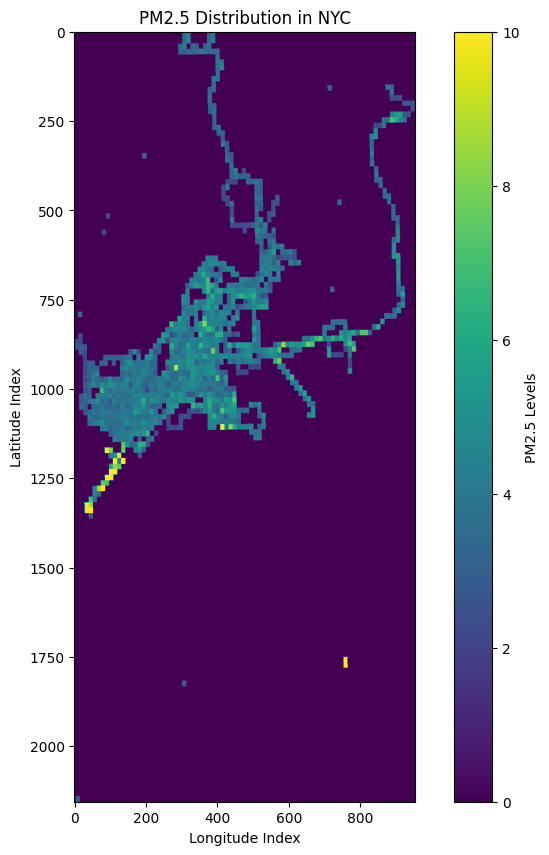

In [248]:
# Load the raster file
with rio.open(full_path) as src:
    data = src.read(1)  # read the first band

# Set up the figure
plt2.figure(figsize=(10, 10))

# Display the raster data with a colormap
plt2.imshow(data, cmap='viridis', vmin=0, vmax=10)  # set the range of the colormap
plt2.colorbar(label='PM2.5 Levels')  # add a color bar

# Add titles and labels if necessary
plt2.title('PM2.5 Distribution in NYC')
plt2.xlabel('Longitude Index')
plt2.ylabel('Latitude Index')

# Show the plot
plt2.show()